Experimented with both the Open and Close price columns for our time series prediction.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [3]:
# Loading the dataset
df_google = pd.read_csv('Google_Stock_Price_Train-1.csv')
print(df_google.head())

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


Pre-processing steps (Using Open column for predictions)

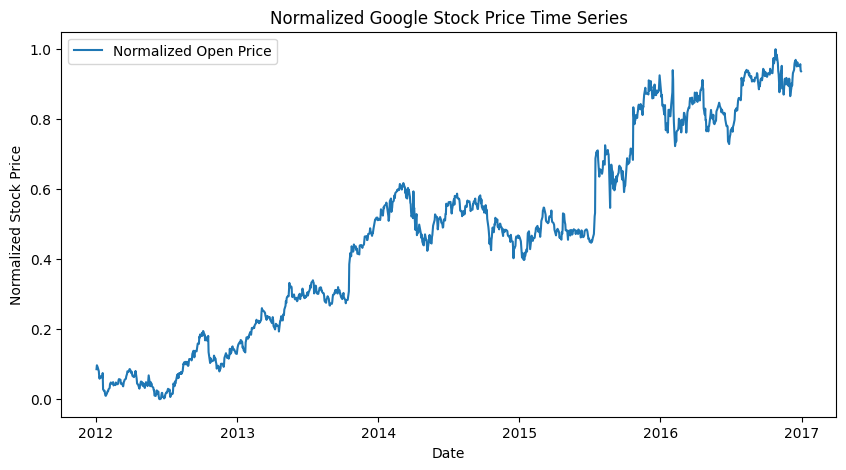

In [4]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Converting the Date column to datetime format
df_google['Date'] = pd.to_datetime(df_google['Date'])

# Sorting date (in case the data is not ordered)
df_google = df_google.sort_values('Date')

# Using only 'Open' column for time series prediction
timeseries_google = df_google[['Open']].values.astype('float32')

# normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries_google = scaler.fit_transform(timeseries_google)

# Ploting the normalized data with dates on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(df_google['Date'], timeseries_google, label="Normalized Open Price")
plt.title("Normalized Google Stock Price Time Series")
plt.xlabel("Date")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()


# Step 3 splitting data as Train-Test (80%-20%) for predictions

In [5]:
train_size_google = int(len(timeseries_google) * 0.80)
test_size_google = len(timeseries_google) - train_size_google
train_google, test_google = timeseries_google[:train_size_google], timeseries_google[train_size_google:]

# Function to transform time series into supervised learning dataset
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback]
        target = dataset[i + 1:i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train_google, y_train_google = create_dataset(train_google, lookback=lookback)
X_test_google, y_test_google = create_dataset(test_google, lookback=lookback)

print(f"X_train shape: {X_train_google.shape}, y_train shape: {y_train_google.shape}")
print(f"X_test shape: {X_test_google.shape}, y_test shape: {y_test_google.shape}")

X_train shape: torch.Size([1002, 4, 1]), y_train shape: torch.Size([1002, 4, 1])
X_test shape: torch.Size([248, 4, 1]), y_test shape: torch.Size([248, 4, 1])


<ipython-input-5-0f1add13e11c>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


# Step 4 Defining and Training the Model

In [6]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model_google = my_LSTM()
optimizer_google = optim.Adam(model_google.parameters())
loss_fn = nn.MSELoss()
loader_google = data.DataLoader(data.TensorDataset(X_train_google, y_train_google), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model_google.train()
    for X_batch, y_batch in loader_google:
        y_pred = model_google(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer_google.zero_grad()
        loss.backward()
        optimizer_google.step()

    # Validation for every 100 epochs
    if epoch % 100 == 0:
        model_google.eval()
        with torch.no_grad():
            y_pred_train = model_google(X_train_google)
            train_rmse = np.sqrt(loss_fn(y_pred_train, y_train_google))
            y_pred_test = model_google(X_test_google)
            test_rmse = np.sqrt(loss_fn(y_pred_test, y_test_google))
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 0: train RMSE 0.1921, test RMSE 0.3904
Epoch 100: train RMSE 0.0151, test RMSE 0.0197
Epoch 200: train RMSE 0.0149, test RMSE 0.0186
Epoch 300: train RMSE 0.0152, test RMSE 0.0203
Epoch 400: train RMSE 0.0152, test RMSE 0.0191
Epoch 500: train RMSE 0.0149, test RMSE 0.0189
Epoch 600: train RMSE 0.0150, test RMSE 0.0192
Epoch 700: train RMSE 0.0151, test RMSE 0.0190
Epoch 800: train RMSE 0.0148, test RMSE 0.0190
Epoch 900: train RMSE 0.0149, test RMSE 0.0194
Epoch 1000: train RMSE 0.0149, test RMSE 0.0192
Epoch 1100: train RMSE 0.0151, test RMSE 0.0203
Epoch 1200: train RMSE 0.0148, test RMSE 0.0194
Epoch 1300: train RMSE 0.0148, test RMSE 0.0191
Epoch 1400: train RMSE 0.0148, test RMSE 0.0192
Epoch 1500: train RMSE 0.0158, test RMSE 0.0208
Epoch 1600: train RMSE 0.0150, test RMSE 0.0198
Epoch 1700: train RMSE 0.0150, test RMSE 0.0197
Epoch 1800: train RMSE 0.0149, test RMSE 0.0197
Epoch 1900: train RMSE 0.0148, test RMSE 0.0199


# Step 5 Ploting Results

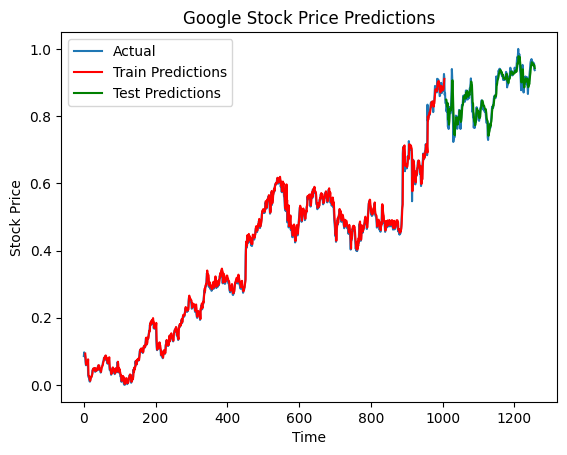

In [7]:
with torch.no_grad():
    # Shifting train predictions for plotting
    train_plot_google = np.ones_like(timeseries_google.flatten()) * np.nan  # Flatten the array
    y_pred_train = model_google(X_train_google)
    y_pred_train = y_pred_train[:, -1, :].squeeze()  # Remove extra dimension
    train_plot_google[lookback:train_size_google] = y_pred_train

    # Shifting test predictions for plotting
    test_plot_google = np.ones_like(timeseries_google.flatten()) * np.nan  # Flatten the array
    y_pred_test = model_google(X_test_google)
    y_pred_test = y_pred_test[:, -1, :].squeeze()  # Remove extra dimension
    test_plot_google[train_size_google + lookback:len(timeseries_google)] = y_pred_test

# Ploting predictions along with the original time series
plt.plot(timeseries_google, label="Actual")
plt.plot(train_plot_google, label="Train Predictions", color='red')
plt.plot(test_plot_google, label="Test Predictions", color='green')
plt.title("Google Stock Price Predictions")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Pre-processing steps (Using Close column for predictions)

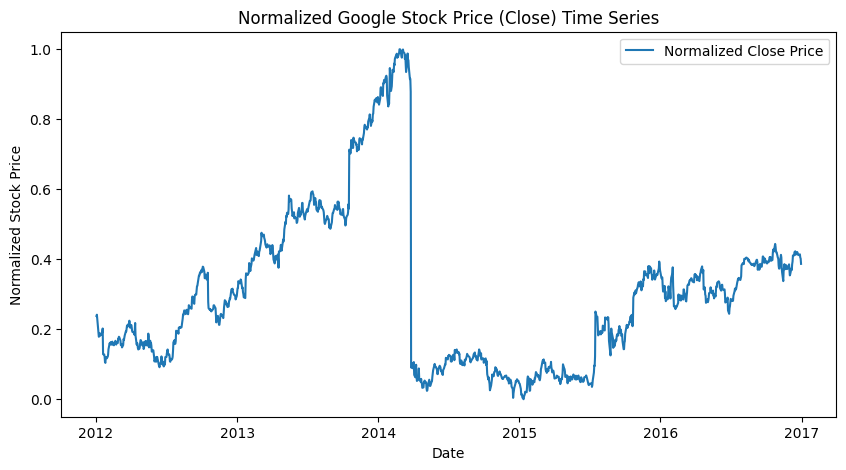

In [8]:
df_google = pd.read_csv('Google_Stock_Price_Train-1.csv')
df_google['Date'] = pd.to_datetime(df_google['Date'])

# Converting the Close column to numeric (removing commas if any)
df_google['Close'] = df_google['Close'].replace(',', '', regex=True).astype(float)

# Sorting by date (in case it's not ordered)
df_google = df_google.sort_values('Date')

# 'Close' column for time series prediction
timeseries_google = df_google[['Close']].values.astype('float32')

# normalizing data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries_google = scaler.fit_transform(timeseries_google)

# Ploting the normalized time series data with dates on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(df_google['Date'], timeseries_google, label="Normalized Close Price")
plt.title("Normalized Google Stock Price (Close) Time Series")
plt.xlabel("Date")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()


# Step 3 splitting data as Train-Test (80%-20%) for predictions

In [9]:
train_size_google = int(len(timeseries_google) * 0.80)
test_size_google = len(timeseries_google) - train_size_google
train_google, test_google = timeseries_google[:train_size_google], timeseries_google[train_size_google:]

# Function to transform time series into supervised learning dataset
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback]
        target = dataset[i + 1:i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train_google, y_train_google = create_dataset(train_google, lookback=lookback)
X_test_google, y_test_google = create_dataset(test_google, lookback=lookback)

print(f"X_train shape: {X_train_google.shape}, y_train shape: {y_train_google.shape}")
print(f"X_test shape: {X_test_google.shape}, y_test shape: {y_test_google.shape}")

X_train shape: torch.Size([1002, 4, 1]), y_train shape: torch.Size([1002, 4, 1])
X_test shape: torch.Size([248, 4, 1]), y_test shape: torch.Size([248, 4, 1])


# Step 4 Defining and Training the Model

In [10]:

# Step 4: Define and Train the Model
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model_google = my_LSTM()
optimizer_google = optim.Adam(model_google.parameters())
loss_fn = nn.MSELoss()
loader_google = data.DataLoader(data.TensorDataset(X_train_google, y_train_google), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model_google.train()
    for X_batch, y_batch in loader_google:
        y_pred = model_google(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer_google.zero_grad()
        loss.backward()
        optimizer_google.step()

    # Validation every 100 epochs
    if epoch % 100 == 0:
        model_google.eval()
        with torch.no_grad():
            y_pred_train = model_google(X_train_google)
            train_rmse = np.sqrt(loss_fn(y_pred_train, y_train_google))
            y_pred_test = model_google(X_test_google)
            test_rmse = np.sqrt(loss_fn(y_pred_test, y_test_google))
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 0: train RMSE 0.1720, test RMSE 0.1068
Epoch 100: train RMSE 0.0288, test RMSE 0.0128
Epoch 200: train RMSE 0.0308, test RMSE 0.0146
Epoch 300: train RMSE 0.0291, test RMSE 0.0132
Epoch 400: train RMSE 0.0291, test RMSE 0.0136
Epoch 500: train RMSE 0.0296, test RMSE 0.0141
Epoch 600: train RMSE 0.0292, test RMSE 0.0140
Epoch 700: train RMSE 0.0297, test RMSE 0.0142
Epoch 800: train RMSE 0.0287, test RMSE 0.0130
Epoch 900: train RMSE 0.0288, test RMSE 0.0129
Epoch 1000: train RMSE 0.0287, test RMSE 0.0128
Epoch 1100: train RMSE 0.0287, test RMSE 0.0128
Epoch 1200: train RMSE 0.0286, test RMSE 0.0127
Epoch 1300: train RMSE 0.0286, test RMSE 0.0128
Epoch 1400: train RMSE 0.0286, test RMSE 0.0133
Epoch 1500: train RMSE 0.0286, test RMSE 0.0132
Epoch 1600: train RMSE 0.0293, test RMSE 0.0132
Epoch 1700: train RMSE 0.0287, test RMSE 0.0128
Epoch 1800: train RMSE 0.0281, test RMSE 0.0130
Epoch 1900: train RMSE 0.0281, test RMSE 0.0130


# Step 5 Ploting Results

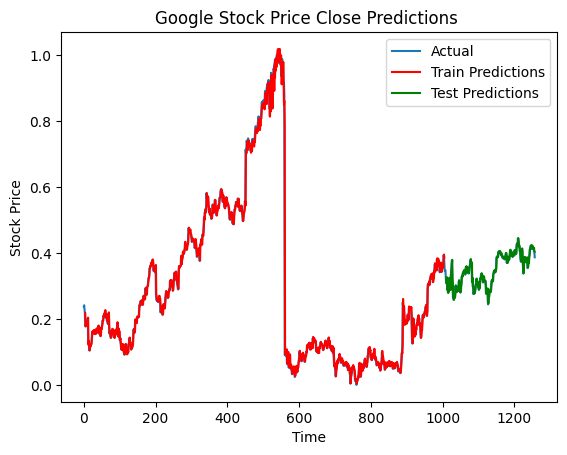

In [11]:
# Step 5: Plot and Report Results
with torch.no_grad():
    # Shift train predictions for plotting
    train_plot_google = np.ones_like(timeseries_google.flatten()) * np.nan  # Flatten the array
    y_pred_train = model_google(X_train_google)
    y_pred_train = y_pred_train[:, -1, :].squeeze()  # Remove extra dimension
    train_plot_google[lookback:train_size_google] = y_pred_train

    # Shift test predictions for plotting
    test_plot_google = np.ones_like(timeseries_google.flatten()) * np.nan  # Flatten the array
    y_pred_test = model_google(X_test_google)
    y_pred_test = y_pred_test[:, -1, :].squeeze()  # Remove extra dimension
    test_plot_google[train_size_google + lookback:len(timeseries_google)] = y_pred_test

# Plot the predictions along with the original time series
plt.plot(timeseries_google, label="Actual")
plt.plot(train_plot_google, label="Train Predictions", color='red')
plt.plot(test_plot_google, label="Test Predictions", color='green')
plt.title("Google Stock Price Close Predictions ")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


The dataset consists of daily Google stock prices from Google_Stock_Price_Train-1.csv. Experimented with both the Open and Close price columns for our time series prediction.

Data Preprocessing
Date Conversion: The Date column was converted to datetime format.
Data Selection:
For each experiment, used either the Open or Close column, normalizing each series independently.
Did normalizing using Min-Max scaling to bring the prices into the range of [0, 1] to stabilize training.
Splitted data into 80-20 by Train-Test Split, with 80% of the data for training and 20% for testing.
Model Architecture:
A simple LSTM model was used with 50 hidden units in 1 LSTM layer, a linear layer used to produce the final output and the model is trained using loss function as the Mean Squared Error (MSE) and optimizer used is Adam and trained with 2000 epochs.

Results
Open Price Prediction:
Train RMSE: The RMSE on the training set converged to a low value, indicating that the model was able to learn the general pattern in the Open prices.
Test RMSE: The RMSE on the test set was slightly higher than the train RMSE, reflecting that while the model generalized reasonably well, some overfitting may still be present.
Prediction Plot: The model’s predictions closely followed the actual Open prices but with minor deviations, particularly on test data.

Close Price Prediction:
Train RMSE: The train RMSE was also low for the Close price, suggesting the model learned the pattern well.
Test RMSE: Similar to the Open price, the test RMSE for Close was slightly higher, again showing some overfitting but acceptable generalization.
Prediction Plot: The predictions on the Close prices matched well with actual values, with minor deviations, especially in volatile regions of the data.